# Machine Learning Engineer Nanodegree
# _Capstone Project_  
 ## _Plant Seedlings Classification Determine the species of a seedling from an image_
 
 By Mayur Selukar

In [1]:
!ls

sample_data


## Google Colab Setup

In [2]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# copying the dataset to local storage of the vm
!cp "/content/drive/My Drive/COLAB_DRIVE/all_new.zip" /content/

In [4]:
# unzipping the data to the required locations
import os
!unzip all_new.zip -d /content/
os.chdir("/content/")
t1 = !unzip train.zip -d /content/
t2 = !unzip test.zip -d /content/

Archive:  all_new.zip
  inflating: /content/sample_submission.csv  
  inflating: /content/test.zip       
  inflating: /content/train.zip      


In [5]:
# checking for gpu runtime
!ls
!nvidia-smi

all_new.zip  sample_data	    test      train
drive	     sample_submission.csv  test.zip  train.zip
Tue Dec 25 16:52:31 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+--------------------------------------------------------------------

## Some Globals

In [0]:
target_size = {
                "VGG16":(224,224),
                "Xception":(299,299),
                "MobileNet":(224,224)
              }
train_data_dir = "/content/train"
test_data_dir = "/content/test"
batch_size = 100

## Contents

### Why We're Here 

Weeds are among the most serious threats to the natural environment and primary production industries. They
displace native species, contribute significantly to land degradation, and reduce farm and forest productivity.

Weeds typically produce large numbers of seeds, assisting their spread, and rapidly invade disturbed sites. Seeds
spread into natural and disturbed environments, via wind, waterways, people, vehicles, machinery, birds and
other animals.

The ability to differentiate a weed from a crop seedling effectively can mean better crop yields and better
stewardship of the environment.

In this notebook, you will make efforts towards developing an algorithm that could be used as part of a mobile or web app. which will be used to classify plants according to their species from the given image


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Plot sample images
* [Step 2](#step2): Input Augmentation
* [Step 3](#step3): Base Model (VGG16 with 2 dense layers)
* [Step 4](#step4): Extract bottelneck features using transfer learing 
* [Step 5](#step5): Classification using bottelneckfeatures
* [Step 6](#step6): Optimization and Tuning 
* [Step 7](#step7): Free Form Visualization
---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dataset

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import os
import seaborn as sns
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.datasets import load_files 
from keras.utils import np_utils
from glob import glob

Using TensorFlow backend.


In [0]:
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm


#### Some helper functions to load images as tensors

In [0]:
# loads image as tensor 
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)
    #return x # just return the 3d tensor as it will be expanded later


In [10]:
# define function to load datasets
def load_dataset(path):
    data = load_files(path)
    ip_files = np.array(data['filenames'])
    ip_targets = np_utils.to_categorical(np.array(data['target']),12 )
    return ip_files, ip_targets

# load datasets
X_train, y_train = load_dataset('/content/train')
X_test, y_test = load_dataset('/content/test')


# load list of plant names
# first 15 characters are of path 
plant_names = [i[15:-1] for i in sorted(glob("/content/train/*/"))]

# print statistics about the dataset
print('There are %d total categories.' % len(plant_names))
print ("Total Images are 4750")
print('There are %s total training images.\n' % len(X_train))
print('There are %s total testing images.\n' % len(X_test))



There are 12 total categories.
Total Images are 4750
There are 3800 total training images.

There are 950 total testing images.



In [11]:
print (X_train[0])
print (y_train[0])

/content/train/Cleavers/c7b4ce2e3.png
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
# How many images per category for training 
for name in plant_names:
    print('{} {} images'.format(name, len(os.listdir(os.path.join("/content/train/", name)))))

Black-grass 217 images
Charlock 311 images
Cleavers 225 images
Common Chickweed 490 images
Common wheat 174 images
Fat Hen 379 images
Loose Silky-bent 528 images
Maize 170 images
Scentless Mayweed 414 images
Shepherds Purse 192 images
Small-flowered Cranesbill 398 images
Sugar beet 302 images


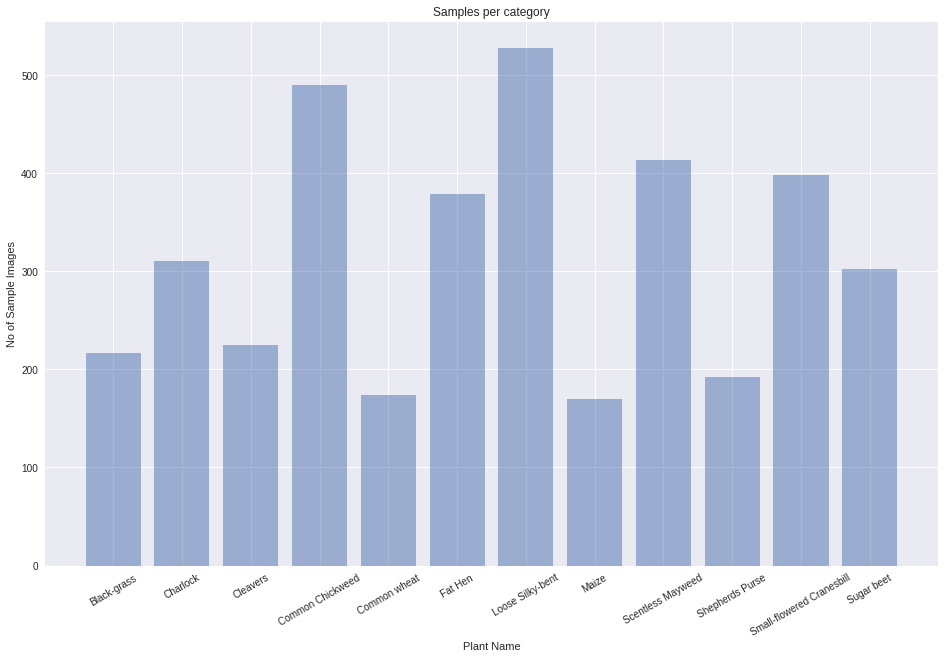

In [16]:
length = []
y_pos = np.arange(len(plant_names))
for name in plant_names:
    length.append(len(os.listdir(os.path.join("/content/train/", name))))
#plt.axis("on")
plt.bar(y_pos, length, align='center', alpha=0.5,)
plt.xticks(y_pos, plant_names,rotation=30)
plt.xlabel('Plant Name')
plt.ylabel('No of Sample Images')
plt.title('Samples per category')
 
plt.show()

The bar graph above represents the unbalanced nature of the dataset with some categories having close to 500 samples and some under 200.

#### Checking Sample Submission file

In [14]:
sample_submission = pd.read_csv('/content/sample_submission.csv')
print (sample_submission.head())

            file     species
0  0021e90e4.png  Sugar beet
1  003d61042.png  Sugar beet
2  007b3da8b.png  Sugar beet
3  0086a6340.png  Sugar beet
4  00c47e980.png  Sugar beet


---
<a id='step1'></a>
## Step 1: Plot Sample Images


In [0]:
# Helper Function to load an image
def read_img(filepath, size=target_size):
    img = image.load_img(filepath, target_size=size)
    img = image.img_to_array(img)
    return img

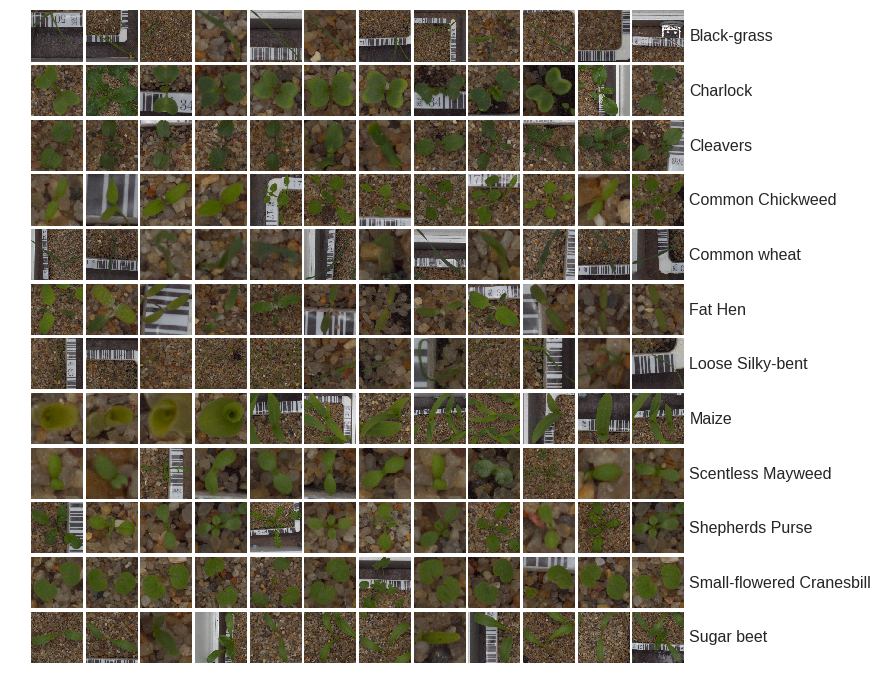

In [19]:
import random
NUM_CATEGORIES = len(plant_names)
CATEGORIES = plant_names
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, cat in enumerate(CATEGORIES):
    filedir = "/content/train/" + cat
    filepaths = os.listdir(filedir)
    for j in range(0,NUM_CATEGORIES,1):
        ax = grid[i*12+j]
        img = read_img(filedir + "/" + random.choice(filepaths), (224,224))
        ax.imshow(img / 255.)
        ax.axis('off')
  
    ax.text(250, 112, cat, verticalalignment='center')    
    i += 1
plt.xlabel("Sample Images")
plt.savefig('/content/drive/My Drive/sample_12.png', format='png', dpi=1000)    
plt.show();


_Some observations:_  
All images are not having the same background and some have what appears to be barcodes in the background, we only need to detect saplings these inconsistent backgrounds will cause our model to take the background as a feature and get the wrong label for the given input.
Due to this nature of the dataset, some performance will be lost.

---
<a id='step2'></a>
## Step 2: Augmenting Images


In [0]:
from keras import applications
from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [18]:
train_datagen_VGG16 = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator_VGG16 = train_datagen_VGG16.flow_from_directory(
    train_data_dir,
    target_size=target_size["VGG16"],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator_VGG16 = train_datagen_VGG16.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=target_size["VGG16"],
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation') # set as validation data


Found 3045 images belonging to 12 classes.
Found 755 images belonging to 12 classes.


---
<a id='step3'></a>
## Step 3: Base Model VGG16 With 2 addititonal layers 


In [19]:
model = applications.VGG16(weights = "imagenet", include_top=False,
                           input_shape = (target_size["VGG16"][0],target_size["VGG16"][1], 3))

58892288/58889256 [==============================] - 3s 0us/step


In [0]:
# Freeze the layers which we don't want to train. Here I am freezing all layers.
for layer in model.layers[0:-1]:
    layer.trainable = False

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation="softmax")(x)

In [23]:
# creating the final model 
model_final = Model(input = model.input, output = predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [24]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

The model is monitering "val_acc" and patience is 5
Once we call fit(... callbacks=[es]) on your model, Keras calls given callback objects predetermined functions. These functions can be called on_train_begin, on_train_end, on_epoch_begin, on_epoch_end and on_batch_begin, on_batch_end. Early stopping callback is called on every epoch end, compares the best monitored value with the current one and stops if conditions are met (how many epochs have past since the observation of the best monitored value and is it more than patience argument, the difference between last value is bigger than min_delta etc..).

model's training will continue until either Early Stopping conditions are met or epochs parameter (default=10) in fit() is satisfied. Setting an Early Stopping callback will not make the model to train beyond its epochs parameter. So calling fit() function with a larger epochs value would benefit more from Early Stopping callback.  

Reference for early stopping: https://stackoverflow.com/questions/43906048/keras-early-stopping

In [0]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')


In [0]:
#!cp "/content/drive/My Drive/COLAB_DRIVE/vgg16_1.h5" "/content/vgg16_1.h5"
#model_final.load_weights("/content/vgg16_1.h5")

In [28]:
model_final.fit_generator(
    train_generator_VGG16,
    steps_per_epoch = train_generator_VGG16.samples // batch_size,
    validation_data = validation_generator_VGG16, 
    validation_steps = validation_generator_VGG16.samples // batch_size,
    epochs = 50,
    callbacks = [checkpoint, early])

Epoch 1/50
30/30 [==============================] - 103s 3s/step - loss: 1.0598 - acc: 0.6253 - val_loss: 0.8853 - val_acc: 0.6871

Epoch 00001: val_acc improved from -inf to 0.68714, saving model to vgg16_1.h5
Epoch 2/50
30/30 [==============================] - 91s 3s/step - loss: 1.0438 - acc: 0.6337 - val_loss: 0.9309 - val_acc: 0.6840

Epoch 00002: val_acc did not improve from 0.68714
Epoch 3/50
30/30 [==============================] - 83s 3s/step - loss: 1.0122 - acc: 0.6537 - val_loss: 0.9201 - val_acc: 0.7084

Epoch 00003: val_acc improved from 0.68714 to 0.70840, saving model to vgg16_1.h5
Epoch 4/50
30/30 [==============================] - 86s 3s/step - loss: 1.0266 - acc: 0.6451 - val_loss: 0.9426 - val_acc: 0.6718

Epoch 00004: val_acc did not improve from 0.70840
Epoch 5/50
30/30 [==============================] - 87s 3s/step - loss: 0.9661 - acc: 0.6564 - val_loss: 0.9012 - val_acc: 0.7099

Epoch 00005: val_acc improved from 0.70840 to 0.70992, saving model to vgg16_1.h5
E

In [29]:
preds = [np.argmax(model_final.predict(path_to_tensor(i))) for i in X_test]

# report test accuracy
#match - np.array()

test_accuracy = 100*np.sum(np.array(preds)==np.argmax(y_test, axis=1))/len(preds)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.1053%


In [0]:
# Copy the saved weights to google drive
#!cp "./vgg16_1.h5" "/content/drive/My Drive/COLAB_DRIVE/vgg16_1_1.h5"#

In [0]:
from sklearn.metrics import f1_score

In [0]:
VGG_16_Densenet_f1 = f1_score(np.argmax(y_test, axis=1), np.array(preds), average='micro')  

In [34]:
print('Test Micro F1 Score is : %.4f' % VGG_16_Densenet_f1)

Test Micro F1 Score is : 0.8011


### Some observations
1. Initially the patience was set to 10 and I believe was set too high for the learning rate of 0.0001 and batch size of 100 patience of 5 is sufficient (later changed in the second run)
2. Testing Acuraccy was consistently lower than validation accuracy 
Hypothesis: I believe that the image augmentation is unnecessary in this case as the images are all centered and aligned in similar ways ( Same as MNIST ).  By doing image augmentation the complexity is incereased when no such examples are present in the testing set.
3. Model takes a log time to train and run We remidy this in the final model

---
<a id='step4'></a>
## Step 4: Extracting Bottelneck Features


*Since the base model is slow and memory heavy we would use transfer learning by extracting bottelneck features 1st and storing them locally 
then we will send these to a Logestic Regression model for classification*  
Due to this approach Data Augmentation is no longer possible 

#### Data Preprocessing

In [0]:
# Renaiming
X = X_train
Y = y_train

In [0]:
# Creating a validation set
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, Y, test_size=0.2, random_state=42)

In [0]:
# converting targets to a single dimensional array from One hot encoded format for Logestic Regression model
y_train_reg = np.array([np.argmax(i) for i in y_train])
y_valid_reg = np.array([np.argmax(i) for i in y_valid])
y_test_reg = np.array([np.argmax(i) for i in y_test])

#### Starting with VGG16

In [0]:
# loding the images as numpy arays
Xtr = np.array([read_img(i,target_size["VGG16"]) for i in X_train])
Xval = np.array([read_img(i,target_size["VGG16"]) for i in X_valid])
Xtst = np.array([read_img(i,target_size["VGG16"]) for i in X_test])

In [0]:
from keras.applications.vgg16 import VGG16

VGG16_bottleneck = VGG16(weights='imagenet', include_top=False,pooling="avg")


In [0]:
def extract_bottelneck_VGG16(x_ip):
    return(VGG16_bottleneck.predict(x_ip, batch_size=32, verbose=1) )
   

In [84]:
X_test_VGG16 = extract_bottelneck_VGG16(Xtst)
X_valid_VGG16 = extract_bottelneck_VGG16(Xval)
X_train_VGG16 = extract_bottelneck_VGG16(Xtr)

3040/3040 [==============================] - 51s 17ms/step


In [0]:
# save the output as a Numpy array
np.save(open('bottleneck_features_train_VGG16.npy', 'wb'), X_train_VGG16)
np.save(open('bottleneck_features_valid_VGG16.npy', 'wb'), X_valid_VGG16)
np.save(open('bottleneck_features_test_VGG16.npy', 'wb'), X_test_VGG16)


In [0]:
# Copy the saved bottelneck features to google drive
!cp "./bottleneck_features_train_VGG16.npy" "/content/drive/My Drive/COLAB_DRIVE/bottleneck_features_train_VGG16.npy"
!cp "./bottleneck_features_valid_VGG16.npy" "/content/drive/My Drive/COLAB_DRIVE/bottleneck_features_valid_VGG16.npy"
!cp "./bottleneck_features_test_VGG16.npy" "/content/drive/My Drive/COLAB_DRIVE/bottleneck_features_test_VGG16.npy"


#### Xception

In [24]:
from keras.applications.xception import Xception

Xception_bottleneck = Xception(include_top=False, weights='imagenet', pooling="avg")

83689472/83683744 [==============================] - 7s 0us/step


In [0]:
# loding the images as numpy arays
Xtr = np.array([read_img(i,target_size["Xception"]) for i in X_train])
Xval = np.array([read_img(i,target_size["Xception"]) for i in X_valid])
Xtst = np.array([read_img(i,target_size["Xception"]) for i in X_test])

In [0]:
def extract_bottleneck_Xception(x_ip):
    return(Xception_bottleneck.predict(x_ip, batch_size=16, verbose=1))

In [27]:
X_test_Xception = extract_bottleneck_Xception(Xtst)
X_valid_Xception = extract_bottleneck_Xception(Xval)
X_train_Xception = extract_bottleneck_Xception(Xtr)

3040/3040 [==============================] - 60s 20ms/step


In [0]:
# save the output as a Numpy array
np.save(open('bottleneck_features_train_Xception.npy', 'wb'), X_train_Xception)
np.save(open('bottleneck_features_valid_Xception.npy', 'wb'), X_valid_Xception)
np.save(open('bottleneck_features_test_Xception.npy', 'wb'), X_test_Xception)


In [0]:
# Copy the saved bottelneck features to google drive
!cp "./bottleneck_features_train_Xception.npy" "/content/drive/My Drive/COLAB_DRIVE/bottleneck_features_train_Xception.npy"
!cp "./bottleneck_features_valid_Xception.npy" "/content/drive/My Drive/COLAB_DRIVE/bottleneck_features_valid_Xception.npy"
!cp "./bottleneck_features_test_Xception.npy" "/content/drive/My Drive/COLAB_DRIVE/bottleneck_features_test_Xception.npy"


__MobileNet__

In [0]:
# loding the images as numpy arays
Xtr = np.array([read_img(i,target_size["MobileNet"]) for i in X_train])
Xval = np.array([read_img(i,target_size["MobileNet"]) for i in X_valid])
Xtst = np.array([read_img(i,target_size["MobileNet"]) for i in X_test])

In [46]:
from keras.applications.mobilenet import MobileNet

MobileNet_bottleneck = MobileNet(weights='imagenet', include_top=False,pooling="avg")

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


17227776/17225924 [==============================] - 1s 0us/step


In [0]:
def extract_bottelneck_MobileNet(x_ip):
    return(MobileNet_bottleneck.predict(x_ip, batch_size=32, verbose=1) )
   

In [86]:
X_test_MobileNet = extract_bottelneck_MobileNet(Xtst)
X_valid_MobileNet = extract_bottelneck_MobileNet(Xval)
X_train_MobileNet = extract_bottelneck_MobileNet(Xtr)

3040/3040 [==============================] - 15s 5ms/step


In [0]:
# save the output as a Numpy array
np.save(open('bottleneck_features_train_MobileNet.npy', 'wb'), X_train_MobileNet)
np.save(open('bottleneck_features_valid_MobileNet.npy', 'wb'), X_valid_MobileNet)
np.save(open('bottleneck_features_test_MobileNet.npy', 'wb'), X_test_MobileNet)


In [0]:
# Copy the saved bottelneck features to google drive
!cp "./bottleneck_features_train_MobileNet.npy" "/content/drive/My Drive/COLAB_DRIVE/bottleneck_features_train_MobileNet.npy"
!cp "./bottleneck_features_valid_MobileNet.npy" "/content/drive/My Drive/COLAB_DRIVE/bottleneck_features_valid_MobileNet.npy"
!cp "./bottleneck_features_test_MobileNet.npy" "/content/drive/My Drive/COLAB_DRIVE/bottleneck_features_test_MobileNet.npy"


---
<a id='step5'></a>
## Step 5: Classification using Bottelneck Features


#### Training a Logestic Regression model on these bottelneck features

__Using VGG16 BNeck Features__

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix


In [72]:
LReg_VGG16 = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42,max_iter=5000)
LReg_VGG16.fit(X_train_VGG16,y_train_reg)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [73]:
valid_preds_VGG16 = LReg_VGG16.predict(X_valid_VGG16)
print('Validation LReg_VGG16 Accuracy {}'.format(accuracy_score(y_valid_reg, valid_preds_VGG16)))

Validation LReg_VGG16 Accuracy 0.7960526315789473


In [76]:
LReg_VGG_16_f1 = f1_score(y_valid_reg , np.array(valid_preds_VGG16), average='micro')  
print ('Validation Micro F1 Score is : %.4f' % LReg_VGG_16_f1)

Validation Micro F1 Score is : 0.7961


__Using Xception BNeck Features__

In [32]:
LReg_Xception = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=0, max_iter= 20000)
LReg_Xception.fit(X_train_Xception,y_train_reg)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=20000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
valid_preds_Xception = LReg_Xception.predict(X_valid_Xception)
print('Validation LReg_Xception Accuracy {}'.format(accuracy_score(y_valid_reg, valid_preds_Xception)))

Validation LReg_Xception Accuracy 0.42105263157894735


In [34]:
LReg_Xception_f1 = f1_score(y_valid_reg, np.array(valid_preds_Xception), average='micro')  
print('Validation Micro F1 Score is : %.4f' % LReg_Xception_f1)

Validation Micro F1 Score is : 0.4211


Logisitc regression model is not converging in the case for Xception bottelneck features   
_The mentor told me to skip the Xception model as the results may not converge for a Logistic Regression classifier without changes in the way bottleneck features were extracted_
I dont want to do this as this would be unfair to the other two models in the comparasion.  
The Results are left as it is  as our target model for feature extraction was MobileNet due to its fast prediction speed.just 1/4th of Xception as visible during feature extraction


__Using MobileNet BNeck Features__

In [49]:
LReg_MobileNet = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42,max_iter=5000)
LReg_MobileNet.fit(X_train_MobileNet,y_train_reg)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [81]:
valid_preds_MobileNet = LReg_MobileNet.predict(X_valid_MobileNet)
print('Validation LReg_MobileNet Accuracy {}'.format(accuracy_score(y_valid_reg, valid_preds_MobileNet)))

Validation LReg_MobileNet Accuracy 0.8171052631578948


In [82]:
LReg_MobileNet_f1 = f1_score(y_valid_reg, np.array(valid_preds_MobileNet), average='micro')  
print('Validation Micro F1 Score is : %.4f' % LReg_MobileNet_f1)

Validation Micro F1 Score is : 0.8171


#### Observation
Simple models like Linear Regression acheived the same peformance as the dense net but with faster prediction, so its clearly better approach for this problem keeping the speed of operation in mind    
To further improve the acuraccy the following things can be done 
1. Use other models like InceptionV3 and MobileNEtV2 for feature extraction
2. Use other ML models for prediction like SGDClassifire, RandomForests, ADAboost
3. Fine tune the ML models
4. Fine tune the models used for feature extraction by freezing a fraction of laters or removing layers 


---
<a id='step6'></a>
## Step 6: Optimizing and Tuning


In [0]:
#solver lbfgs only takes 12 as penalty so this hyperparameter cant be changed
C = np.logspace(0, 4, 10)
#Create hyperparameter options
hyperparameters = dict(penalty=penalty)

X_final = np.concatenate((X_train_MobileNet,X_valid_MobileNet), axis = 0)
Y_final = np.concatenate((y_train_reg,y_valid_reg), axis = 0)

In [0]:
# Create grid search using 5-fold cross validation
from sklearn.model_selection import GridSearchCV
LReg_Final = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, max_iter=5000)
clf = GridSearchCV(LReg_Final, hyperparameters, cv = 5, verbose=0,n_jobs = -1)

In [0]:
# Fit grid search
best_model = clf.fit(X_final,Y_final)

In [123]:
# View best hyperparameter
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best C: 1.0


In [0]:
test_preds_MobileNet_final = clf.predict(X_test_MobileNet)

In [125]:
LReg_best_model_f1 = f1_score(np.argmax(y_test, axis=1), np.array(test_preds_MobileNet_final), average='micro')  
print('Test Micro F1 Score is : %.4f' % LReg_best_model_f1)

Test Micro F1 Score is : 0.8474


---
<a id='step7'></a>
## Step 7: Freeform Visualization


In [0]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test_reg, test_preds_MobileNet_final)

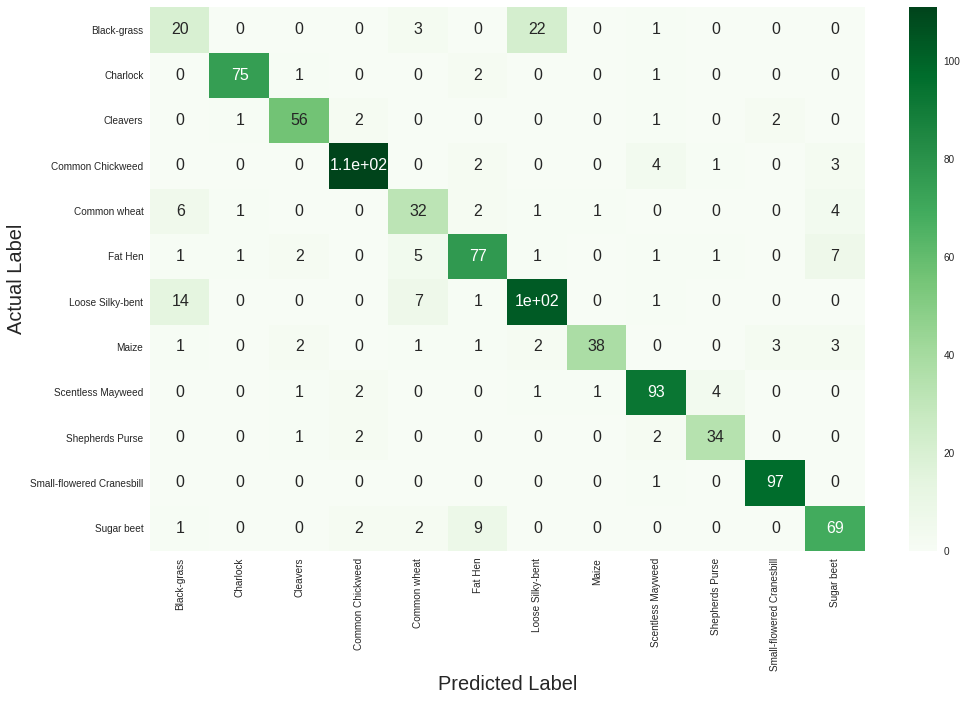

In [148]:
ax = sns.heatmap(cnf_matrix, cmap=plt.cm.Greens, annot=True,  xticklabels=plant_names, yticklabels=plant_names)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_ylabel('Actual Label', fontsize=20)
ax.set_xlabel('Predicted Label', fontsize=20)
plt.show()

We can see in the confusion matrix above, that the major misclassification happened between Loose Silky-bent and Black-grass.
The classifier is having difficulty distinguishing these two classes apart out of the 125 samples of  Loose Silky-bent 14 were marked as Black Grass and 7 as Common Wheat which is also significant.

The situation is much worse in case of Black Grass out of the 43 samples 22 were marked as Loose Silky bent. The Imbalanced nature of the dataset can be seen here

This is were the classifier needs improvement as this amounts to the majority of the miss classifications  

#### Reflections
Working on this problem has taught me a lot although not implemented I learned about masking. I learned about Image Augmentation and transfer learning. I also explored how CNN’s can be used in conjunction with the traditional Machine learning models.

The major difficulty I faced was initially to restructure the dataset as although the dataset could be loaded into memory this was not desirable as It will not always be possible. The second issue was when the Xception features did not converge with a Logistics regression Classifire and were later cleared by the mentor The mentor told me to skip the Xception model as the results may not converge for a Logistic Regression classifier without changes in the way bottleneck features were extracted

This project gave me a good insight on how to deal with future image classification problems and encouraged me to work on further improving my current model especially try out masking the background and to use augmentation to balance the dataset. It is satisfying to see that the final model performs exceptionally well and I can’t wait to work on other projects